## Part 1 Step 3 : 

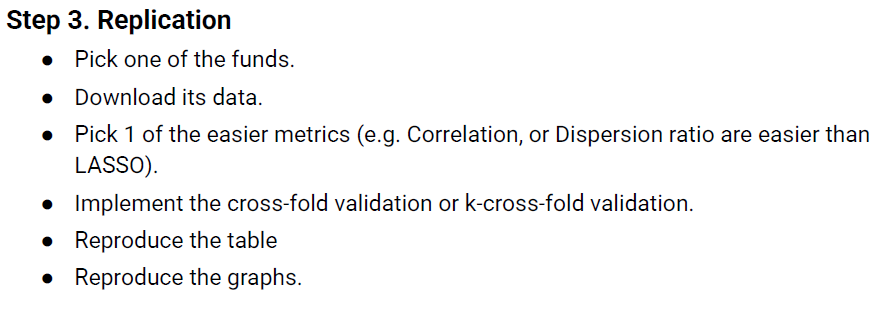

# BlackRock’s ETFs : 
ECH, EWZ, and iShares Core S&P 500 ETF (IVV)

In [3]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os
import datetime
import inspect
from finta import TA

In [113]:
# 1. Picking one of the fund. Time range : 12 December 2009 to 1 January 2020
start = datetime.date(2009, 12, 12)
end = datetime.date(2020, 1, 1)
formatted_startdate = start.strftime("%d-%m-%y")
formatted_enddate = end.strftime("%d-%m-%y")

# Get ETF data
filename = "ETF " + formatted_startdate + " to " + formatted_enddate + ".csv"
ETFs = ["ECH", "EWZ", "IVV"]

In [115]:
# 2. Download its data
dfs = []
for ETF in ETFs : 
    filename = ETF + " " + formatted_startdate + " to " + formatted_enddate + ".csv"

    if os.path.exists(filename) : 
        df = pd.read_csv(filename)

        # Ensure Date is parsed as datetime
        df["Date"] = pd.to_datetime(df["Date"])

        # Rename columns to lowercase
        df = df.rename(columns=str.lower)

        # Reorder so Date is the first column
        cols = ["date"] + [c for c in df.columns if c != "date"]
        df = df[cols]

        print("File exist")

        data = df
        data.index = data["date"]
        data.index.name = ""
        data = data.drop(columns = ["date"])
        data.index = data.index.date
        dfs.append(data)
    else : 
        df = yf.download(ETF, start, end, auto_adjust = False)
        # Convert DataFrame index to timezone-aware (UTC)
        df.index = df.index.tz_localize('UTC')

        #Flatten column : 
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        #Renaming column : 
        df = df.rename(columns = str.lower)

        #Save file : 
        df.to_csv(filename)
        print("Downloaded")

        df.index = df.index.date
        dfs.append(df)

File exist
File exist
File exist


In [116]:
df_ECH = dfs[0]
df_EWZ = dfs[1]
df_IVV = dfs[2]

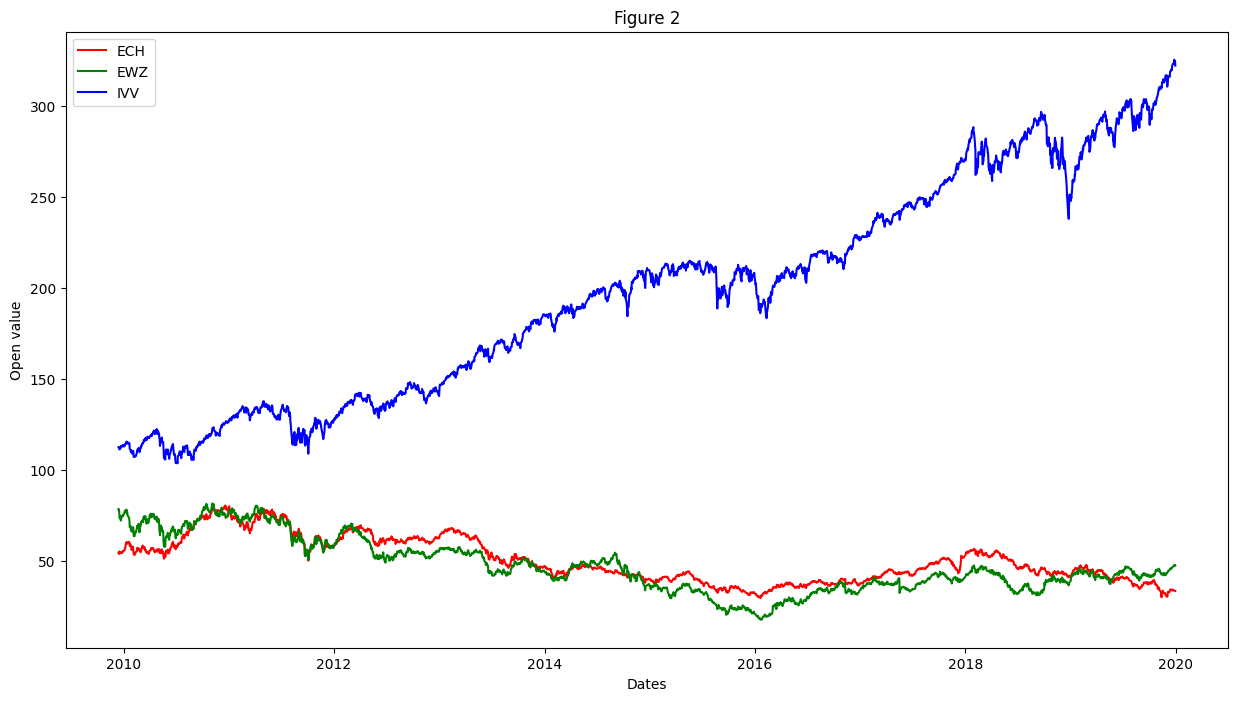

In [117]:
# Reproducing graph in figure 2
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(df_ECH.index, df_ECH["open"], color = "red")
ax.plot(df_EWZ.index, df_EWZ["open"], color = "green")
ax.plot(df_IVV.index, df_IVV["open"], color = "blue")
plt.legend(ETFs)
plt.xlabel("Dates")
plt.ylabel("Open value")
plt.title("Figure 2")
plt.show()

fig.savefig("Figure 2 Behavior of Open values for ECH EWZ and IVV.png", bbox_inches = "tight")

In [70]:
df_ECH["open"].median()

46.45000076293945

In [118]:
# Summary of open data : 
summary_open = pd.DataFrame( {
    "ECH" : [df_ECH["open"].min(), df_ECH["open"].quantile(0.25), df_ECH["open"].median(), df_ECH["open"].mean(), df_ECH["open"].quantile(0.75), df_ECH["open"].max()],
    "EWZ" : [df_EWZ["open"].min(), df_EWZ["open"].quantile(0.25), df_EWZ["open"].median(), df_EWZ["open"].mean(), df_EWZ["open"].quantile(0.75), df_EWZ["open"].max()],
    "IVV" : [df_IVV["open"].min(), df_IVV["open"].quantile(0.25), df_IVV["open"].median(), df_IVV["open"].mean(), df_IVV["open"].quantile(0.75), df_IVV["open"].max()]}, 
    index = ["Min", "1st Quantile", "Median", "Mean", "3rd Quantile", "Max"]
)

summary_open = round(summary_open, 2)
summary_open

,ECH,EWZ,IVV
Min,29.30,17.49,103.48
1st Quantile,40.34,36.69,138.32
Median,46.45,43.60,199.39
Mean,50.09,47.14,196.96
3rd Quantile,59.85,56.09,244.81
Max,80.25,81.41,325.19


## Algorithm 2 Part 1 : 

Input: ETF raw datasets <br>
1. for each ETF do <br>
2. Calculate each technical indicator <br>
3. Class assignment <br>
4. Normalization of the data <br>
5. Cleaning of the data <br>
6. end for <br>

In [72]:
# Finding the values of Gamma
def FindingGamma(OpenData) : 
    Gamma_sum = [0]
    Gamma = [0]

    for i in range (1, len(OpenData)) : 
        Gamma_sum.append( (Gamma_sum[i-1] + 1) if (OpenData.iloc[i] > OpenData.iloc[i-1]) 
                     else (Gamma_sum[i-1] - 1) )
        Gamma.append( (1) if (OpenData.iloc[i] > OpenData.iloc[i-1]) 
                     else (-1) )

    return Gamma_sum, Gamma

# Obtaining all technical indicators
def CalculateAllIndicator_TA(df) : 
    indicators = [func for func in dir(TA) if func.isupper()]

    for ind in indicators:
        try:
            func = getattr(TA, ind)
            sig = inspect.signature(func)

            # If the function only takes df → call directly
            if len(sig.parameters) == 1:
                result = func(df)

            # If it takes df + something else → skip or supply defaults
            else:
                # Example: ADL(df, 'volume'), ATR(df, 14), etc.
                # You can hardcode defaults here:
                if ind == "ADL":
                    result = func(df, "volume")
                elif ind in ("ATR", "RSI", "EMA", "SMA"):
                    result = func(df, 14)  # default period
                

            # Attach results
            if isinstance(result, pd.Series):
                df[ind] = result
            elif isinstance(result, pd.DataFrame):
                for col in result.columns:
                    df[f"{ind}_{col}"] = result[col]

        except Exception as e:
            print(f"Skipping {ind}: {e}")
    
    return df

def MinMaxNormalization(dataframe):
    df_norm = dataframe.copy()
    for col in df_norm.columns:
        min_val = df_norm[col].min()
        max_val = df_norm[col].max()
        if max_val != min_val:  # avoid division by zero
            df_norm[col] = (df_norm[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0.0
    return df_norm

def Algorithm2_Program1(dataframe) :     
    #Calculate technical indicator : 
    dataframe_ta = CalculateAllIndicator_TA(dataframe)

    # Class Assignment :
    Gamma_sum, Gamma = FindingGamma(dataframe["open"]) 
    Gamma = pd.Series(Gamma).map({-1: 0, 1: 1}).dropna()
    Gamma_sum = pd.Series(Gamma_sum).dropna()

    
    # Min-Max Data Normalization 
    dataframe_ta_norm = MinMaxNormalization(dataframe_ta)

    #Data Cleaning : 
    dataframe_ta_norm = dataframe_ta_norm.dropna()
    dataframe_ta = dataframe_ta.dropna()
    return dataframe_ta_norm, Gamma_sum, Gamma, dataframe_ta

## Algorithm 2 Part 2 : 
Input: Preprocessed ETF datasets <br>
7. for each ETF do <br>
8. for each Statistical measure do <br>
9. Obtain the first quartile of the top salient features. <br>
10. end for <br>
11. Calculate the sets Selected (n)= { f ∈ Features ∣f appears in at least n subsets defined in (5)} <br>
12. end for <br>

The statistical measures to be taken will be Dispersion Ratio

In [73]:
#Dispersion Ratio as Filter : 
import scipy.stats as stats

def CalculateDispersionRatio(dataframe) : 
    DispersionRatio = []
        
    for col in dataframe.columns : 
        data = dataframe[col]
        arithmetic_mean = data.mean()
        geometric_mean = stats.gmean(data + 1e-2)
        DispersionRatio.append(arithmetic_mean/geometric_mean) 
    return DispersionRatio

def Jaccard_Distance(set1, set2) : 
    intersection_12 = set1.intersection(set2)
    union_12 = set1.union(set2)
    return 1 - len(intersection_12)/len(union_12)

def DispersionRatio_Filter(dataframe, topquartile_val) :
    #Calculate dispersion ratio :  
    ratio = CalculateDispersionRatio(dataframe)

    # Convert to dataframe :
    col = dataframe.columns
    df_ratio = pd.DataFrame({"dispersion ratio" : ratio}, index = col) 

    # Sorting descending : 
    df_ratio = df_ratio.sort_values("dispersion ratio", ascending = False)

    # Select top quartile : 
    num_topquartile = int(topquartile_val*len(df_ratio))
    top_quartile = df_ratio.head(num_topquartile)

    return top_quartile, df_ratio

## Algorithm 2 Part 3 : 
Input: Subsets of selected features <br>
Output: mean(a_i) <br>
13. for i ← 0 to 8 do <br>
14. for each K-fold cross validation partition do <br>
15. Feed the MLP with the features in selected (i). <br>
16. Obtain the model’s accuracy, ai <br>
17. end for <br>
18. Obtain a central tendency measure, mean(a_i) <br>
19. end for <br>

In [74]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

def MLP_n_CrossValidation(feature, Categories, num_splits) : #feature and Categories are dataframe
    n_feature = feature.shape[0]
    n_classes = len(np.unique(Categories))
    hidden_layer_sizes = int( (n_feature + n_classes)/2 )
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                          activation='logistic', 
                          solver='lbfgs', 
                          batch_size='auto', 
                          learning_rate='adaptive', 
                          learning_rate_init=0.03, 
                          max_iter=5000, 
                          momentum=0.2, 
                          random_state=np.random.get_state()[1][0], 
                          early_stopping=False)
    
    # cross-validate knn on our training sample with nof_folds=10
    cv_generator = StratifiedKFold(n_splits=num_splits,shuffle=False)
    accuracy_score = []

    for train_idx, test_idx in cv_generator.split(feature,Categories) : 
        X_train, X_test = feature.iloc[train_idx], feature.iloc[test_idx]
        y_train, y_test = Categories.iloc[train_idx], Categories.iloc[test_idx]
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        accuracy_score.append(acc)
    return accuracy_score

def Algorithm2_Program3(TopQuartile, Gamma, df_ta_norm, num_splits) : #Those three must be dataframe
    selected_feature = TopQuartile.index.to_list()
    X = df_ta_norm[selected_feature]
    Y = Gamma

    accuracy_score = MLP_n_CrossValidation(X, Y, num_splits)
    return accuracy_score

# Execution

In [75]:
def Initial_Execution(df_ECH, df_EWZ, df_IVV) : 
    # Part 1 : 
    df_ECH_ta_norm, Gamma_sum_ECH, Gamma_ECH, df_ECH_ta = Algorithm2_Program1(df_ECH)
    df_EWZ_ta_norm, Gamma_sum_EWZ, Gamma_EWZ, df_EWZ_ta = Algorithm2_Program1(df_EWZ)
    df_IVV_ta_norm, Gamma_sum_IVV, Gamma_IVV, df_IVV_ta = Algorithm2_Program1(df_IVV)

    df_Gamma_sum = pd.DataFrame( {
        "ECH" : Gamma_sum_ECH, 
        "EWZ" : Gamma_sum_EWZ,
        "IVV" : Gamma_sum_IVV
    } )

    df_Gamma = pd.DataFrame( {
        "ECH" : Gamma_ECH, 
        "EWZ" : Gamma_EWZ,
        "IVV" : Gamma_IVV
    })

    df_Gamma = df_Gamma.tail(len(df_ECH_ta_norm))
    df_Gamma_sum = df_Gamma_sum.tail(len(df_ECH_ta_norm))

    print(f"Percentage of data being cleaned in ECH = {100 - len(df_ECH_ta) / len(df_ECH)*100}%")
    print(f"Percentage of data being cleaned in EWZ = {100 - len(df_EWZ_ta) / len(df_ECH)*100}%")
    print(f"Percentage of data being cleaned in IVV = {100 - len(df_IVV_ta) / len(df_ECH)*100}%")

    fig = plt.figure(figsize = (12,8))
    df_Gamma_sum["ECH"].plot(color = "red", legend=True)
    df_Gamma_sum["EWZ"].plot(color = "green", legend=True)
    df_Gamma_sum["IVV"].plot(color = "blue", legend=True)

    plt.xlabel("Days")
    plt.ylabel("Cumulative (Γ)")
    plt.title("Γ Cumulative Movements for ECH, EWZ, IVV")
    fig.savefig("Figure 3 Cumulative Movements for ECH EWZ and IVV.png", bbox_inches = "tight")

    return df_ECH_ta_norm, df_EWZ_ta_norm, df_IVV_ta_norm, df_Gamma, df_Gamma_sum

In [76]:
def Variable_Execution(quartile_proportion, df_ECH_ta_norm, df_EWZ_ta_norm, df_IVV_ta_norm, df_Gamma, num_splits) : 
    # Part 2 : 
    TopQuartile_ECH, DispersionRatioSorted_ECH = DispersionRatio_Filter(df_ECH_ta_norm, quartile_proportion)
    TopQuartile_EWZ, DispersionRatioSorted_EWZ = DispersionRatio_Filter(df_EWZ_ta_norm, quartile_proportion)
    TopQuartile_IVV, DispersionRatioSorted_IVV = DispersionRatio_Filter(df_IVV_ta_norm, quartile_proportion)

    # Calculating Jaccard Distance
    set_ECH = set(TopQuartile_ECH.index)
    set_EWZ = set(TopQuartile_EWZ.index)
    set_IVV = set(TopQuartile_IVV.index)

    JaccardDistance_ECH_EWZ = Jaccard_Distance(set_ECH, set_EWZ)
    JaccardDistance_ECH_IVV = Jaccard_Distance(set_ECH, set_IVV)
    JaccardDistance_EWZ_IVV = Jaccard_Distance(set_IVV, set_EWZ)

    print(f"Jaccard distance between ECH dan EWZ : {JaccardDistance_ECH_EWZ}")
    print(f"Jaccard distance between ECH dan IVV : {JaccardDistance_ECH_IVV}")
    print(f"Jaccard distance between EWZ dan IVV : {JaccardDistance_EWZ_IVV}")


    # Part 3 : 
    accuracy_score_ECH = Algorithm2_Program3(TopQuartile_ECH, df_Gamma["ECH"], df_ECH_ta_norm, 10)
    accuracy_score_EWZ = Algorithm2_Program3(TopQuartile_EWZ, df_Gamma["EWZ"], df_EWZ_ta_norm, 10)
    accuracy_score_IVV = Algorithm2_Program3(TopQuartile_IVV, df_Gamma["IVV"], df_IVV_ta_norm, 10)

    df_accuracy_score = pd.DataFrame({
        "ECH" : Algorithm2_Program3(TopQuartile_ECH, df_Gamma["ECH"], df_ECH_ta_norm, num_splits),
        "EWZ" : Algorithm2_Program3(TopQuartile_EWZ, df_Gamma["EWZ"], df_EWZ_ta_norm, num_splits),
        "IVV" : Algorithm2_Program3(TopQuartile_IVV, df_Gamma["IVV"], df_IVV_ta_norm, num_splits)
    }, columns = ETFs)

    df_accuracy_score.describe()
    return df_accuracy_score

Percentage of data being cleaned in ECH = 0.5140371688414405%
Percentage of data being cleaned in EWZ = 0.5140371688414405%
Percentage of data being cleaned in IVV = 0.5140371688414405%


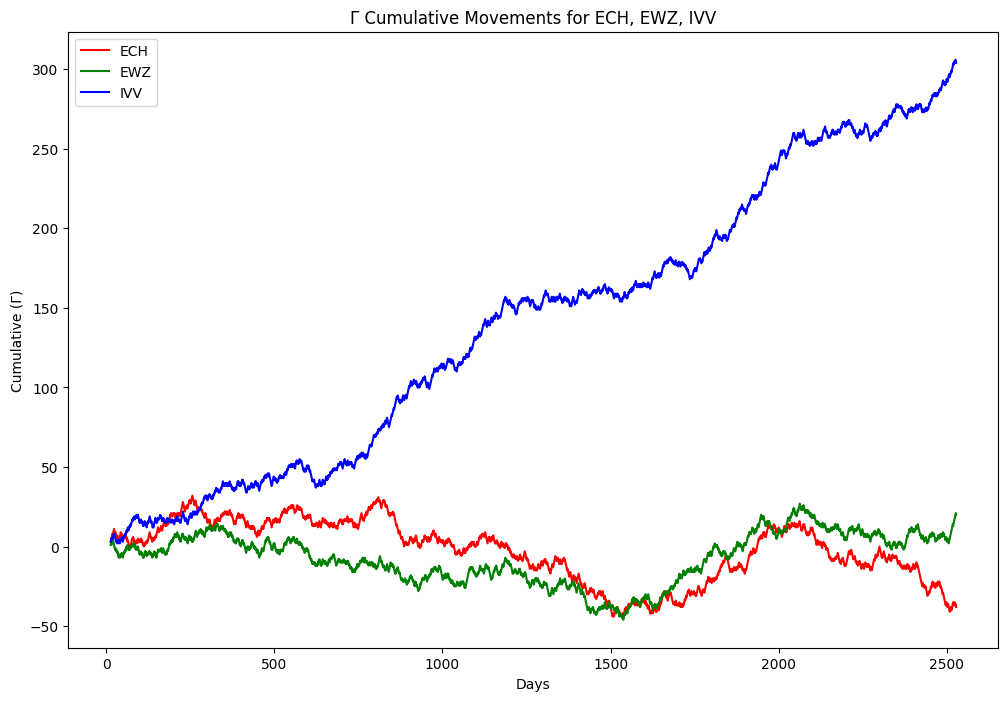

In [120]:
df_ECH_ta_norm, df_EWZ_ta_norm, df_IVV_ta_norm, df_Gamma, df_Gamma_sum = Initial_Execution(df_ECH, df_EWZ, df_IVV)

In [68]:
results = {
    "Mean": [],
    "Median": [],
    "Q1": [],
    "Q3": [], 
    "Min" : [],
    "Max" : []
}

quartile_start = 1
quartile_end = 30
quartile_stepsize = 1
num_step = int((quartile_end - quartile_start) / (quartile_stepsize) + 1)
quartile_sequence = np.linspace(quartile_start, quartile_end, num_step)

for quartile_percentage in quartile_sequence:
    print("Quartile = ", quartile_percentage)
    quartile = quartile_percentage / 100
    accuracy = Variable_Execution(quartile, df_ECH_ta_norm, df_EWZ_ta_norm, df_IVV_ta_norm, df_Gamma, 10)
    
    # Collect stats across ETFs
    results["Mean"].append(accuracy.mean())
    results["Median"].append(accuracy.median())
    results["Q1"].append(accuracy.quantile(0.25))
    results["Q3"].append(accuracy.quantile(0.75))
    results["Min"].append(accuracy.min())
    results["Max"].append(accuracy.max())

# Now build a summary DataFrame
accuracy_overall = pd.DataFrame({
    "ECH": [pd.concat(results["Min"], axis=1).loc["ECH"].min(),
            pd.concat(results["Q1"], axis=1).loc["ECH"].mean(),
            pd.concat(results["Mean"], axis=1).loc["ECH"].mean(),
            pd.concat(results["Median"], axis=1).loc["ECH"].mean(),
            pd.concat(results["Q3"], axis=1).loc["ECH"].mean(),
            pd.concat(results["Max"], axis=1).loc["ECH"].max()],
    
    "EWZ": [pd.concat(results["Min"], axis=1).loc["EWZ"].min(),
            pd.concat(results["Q1"], axis=1).loc["EWZ"].mean(),
            pd.concat(results["Mean"], axis=1).loc["EWZ"].mean(),
            pd.concat(results["Median"], axis=1).loc["EWZ"].mean(),
            pd.concat(results["Q3"], axis=1).loc["EWZ"].mean(),
            pd.concat(results["Max"], axis=1).loc["EWZ"].max()],
    
    "IVV": [pd.concat(results["Min"], axis=1).loc["IVV"].min(),
            pd.concat(results["Q1"], axis=1).loc["IVV"].mean(),
            pd.concat(results["Mean"], axis=1).loc["IVV"].mean(),
            pd.concat(results["Median"], axis=1).loc["IVV"].mean(),
            pd.concat(results["Q3"], axis=1).loc["IVV"].mean(),
            pd.concat(results["Max"], axis=1).loc["IVV"].max()]
}, index=["Min", "25%", "Mean", "Median", "75%", "Max"])

Quartile =  1.0
Jaccard distance between ECH dan EWZ : 0.0
Jaccard distance between ECH dan IVV : 0.0
Jaccard distance between EWZ dan IVV : 0.0
Quartile =  2.0
Jaccard distance between ECH dan EWZ : 0.8
Jaccard distance between ECH dan IVV : 0.8
Jaccard distance between EWZ dan IVV : 0.5
Quartile =  3.0
Jaccard distance between ECH dan EWZ : 0.8571428571428572
Jaccard distance between ECH dan IVV : 0.6666666666666667
Jaccard distance between EWZ dan IVV : 0.4
Quartile =  4.0
Jaccard distance between ECH dan EWZ : 0.6666666666666667
Jaccard distance between ECH dan IVV : 0.5
Jaccard distance between EWZ dan IVV : 0.5
Quartile =  5.0
Jaccard distance between ECH dan EWZ : 0.4444444444444444
Jaccard distance between ECH dan IVV : 0.4444444444444444
Jaccard distance between EWZ dan IVV : 0.4444444444444444
Quartile =  6.0
Jaccard distance between ECH dan EWZ : 0.0
Jaccard distance between ECH dan IVV : 0.0
Jaccard distance between EWZ dan IVV : 0.0
Quartile =  7.0
Jaccard distance between

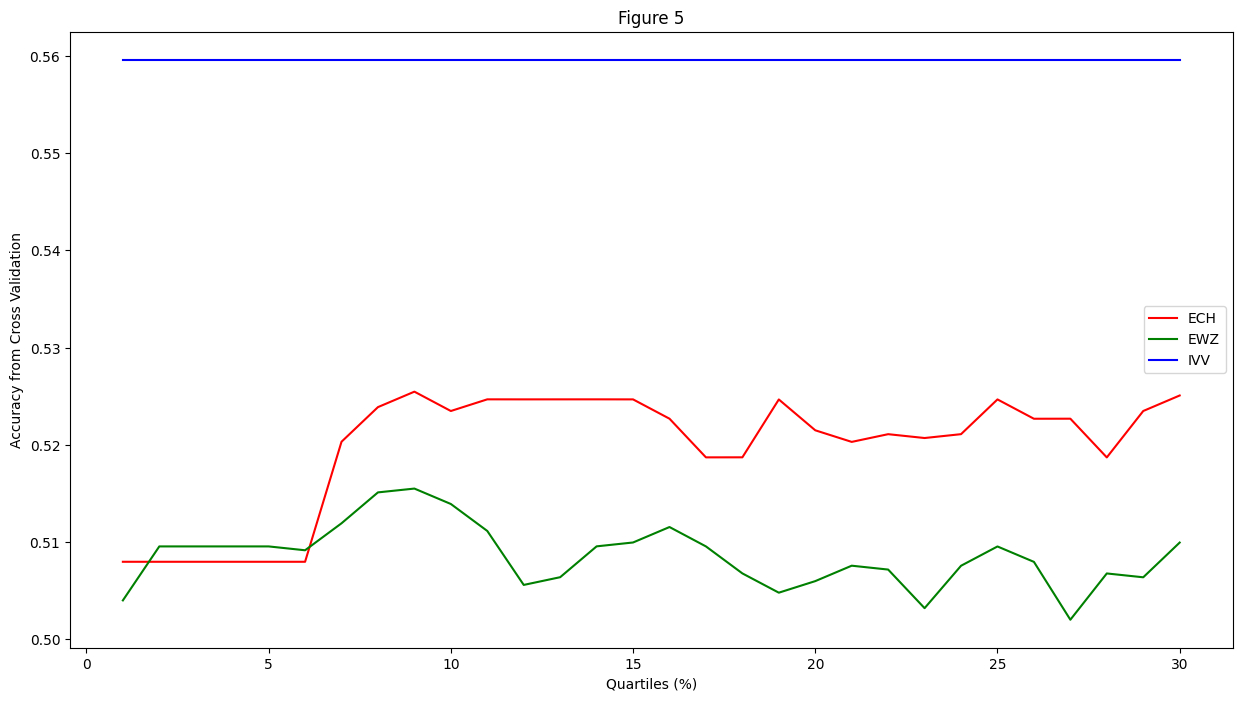

In [69]:
# Individual Mean data
accuracy_individual_quartile_mean = pd.DataFrame(results["Mean"])
accuracy_individual_quartile_mean.index = quartile_sequence
accuracy_individual_quartile_mean.index.name = "Quartile"

# Reproducing graph in figure 2
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(accuracy_individual_quartile_mean.index, accuracy_individual_quartile_mean["ECH"], color = "red")
ax.plot(accuracy_individual_quartile_mean.index, accuracy_individual_quartile_mean["EWZ"], color = "green")
ax.plot(accuracy_individual_quartile_mean.index, accuracy_individual_quartile_mean["IVV"], color = "blue")
plt.legend(ETFs)
plt.xlabel("Quartiles (%)")
plt.ylabel("Accuracy from Cross Validation")
plt.title("Figure 5")
plt.show()

fig.savefig("Figure 5 Accuracy from Cross Validation (Mean).png", bbox_inches = "tight")

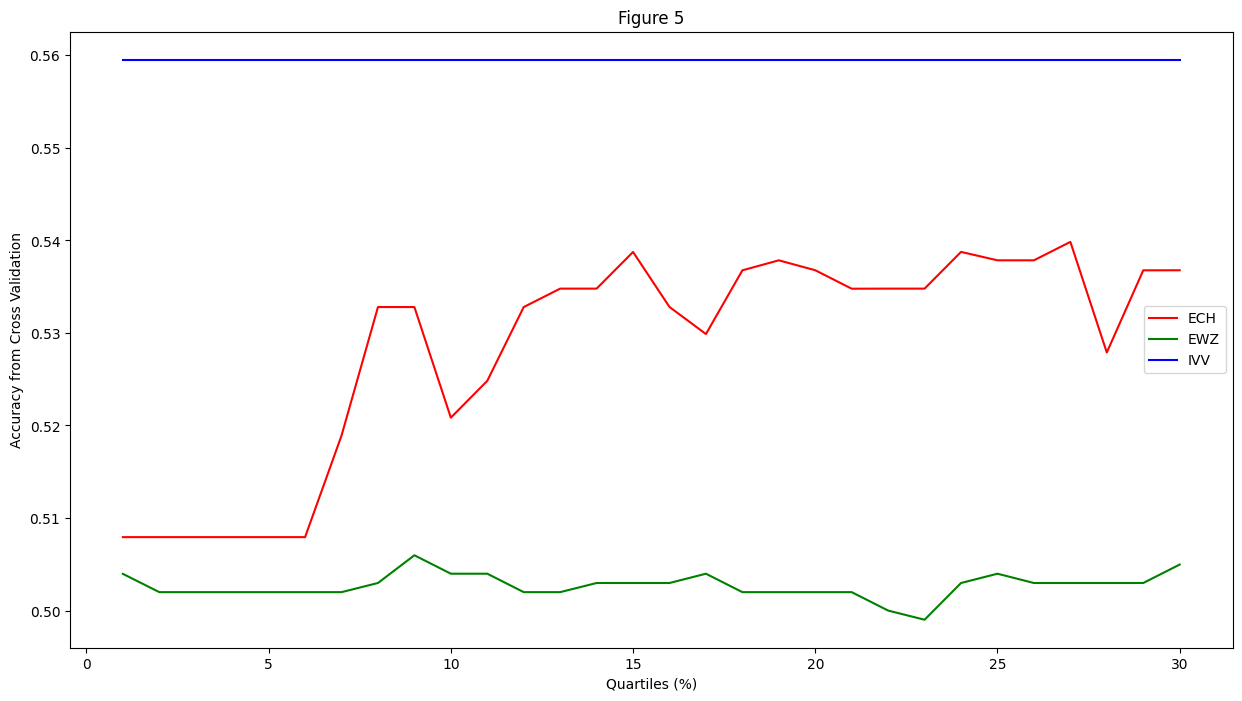

In [75]:
# Individual Median data
accuracy_individual_quartile_median = pd.DataFrame(results["Median"])
accuracy_individual_quartile_median.index = quartile_sequence
accuracy_individual_quartile_median.index.name = "Quartile"

# Reproducing graph in figure 2
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(accuracy_individual_quartile_median.index, accuracy_individual_quartile_median["ECH"], color = "red")
ax.plot(accuracy_individual_quartile_median.index, accuracy_individual_quartile_median["EWZ"], color = "green")
ax.plot(accuracy_individual_quartile_median.index, accuracy_individual_quartile_median["IVV"], color = "blue")
plt.legend(ETFs)
plt.xlabel("Quartiles (%)")
plt.ylabel("Accuracy from Cross Validation")
plt.title("Figure 5")
plt.show()

fig.savefig("Figure 5 Accuracy from Cross Validation (Median).png", bbox_inches = "tight")

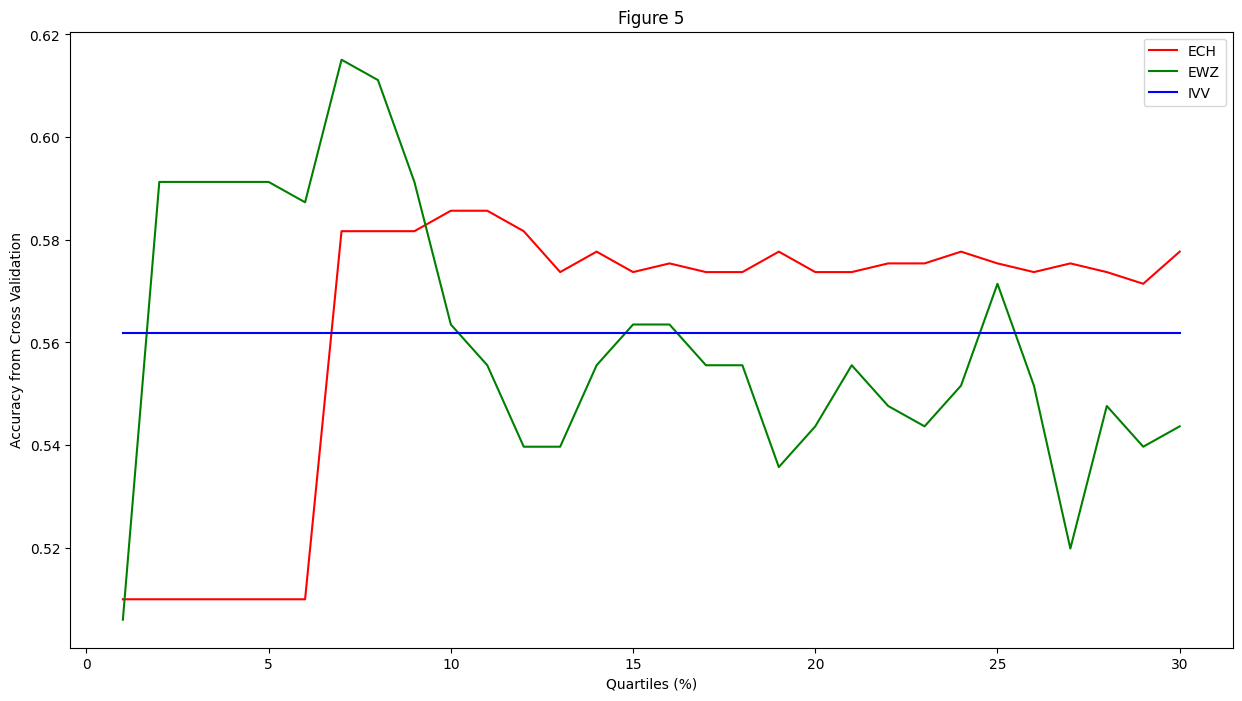

In [84]:
# Individual Max data
accuracy_individual_quartile_max = pd.DataFrame(results["Max"])
accuracy_individual_quartile_max.index = quartile_sequence
accuracy_individual_quartile_max.index.name = "Quartile"

# Reproducing graph in figure 2
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(accuracy_individual_quartile_max.index, accuracy_individual_quartile_max["ECH"], color = "red")
ax.plot(accuracy_individual_quartile_max.index, accuracy_individual_quartile_max["EWZ"], color = "green")
ax.plot(accuracy_individual_quartile_max.index, accuracy_individual_quartile_max["IVV"], color = "blue")
plt.legend(ETFs)
plt.xlabel("Quartiles (%)")
plt.ylabel("Accuracy from Cross Validation")
plt.title("Figure 5")
plt.show()

fig.savefig("Figure 5 Accuracy from Cross Validation (Max).png", bbox_inches = "tight")

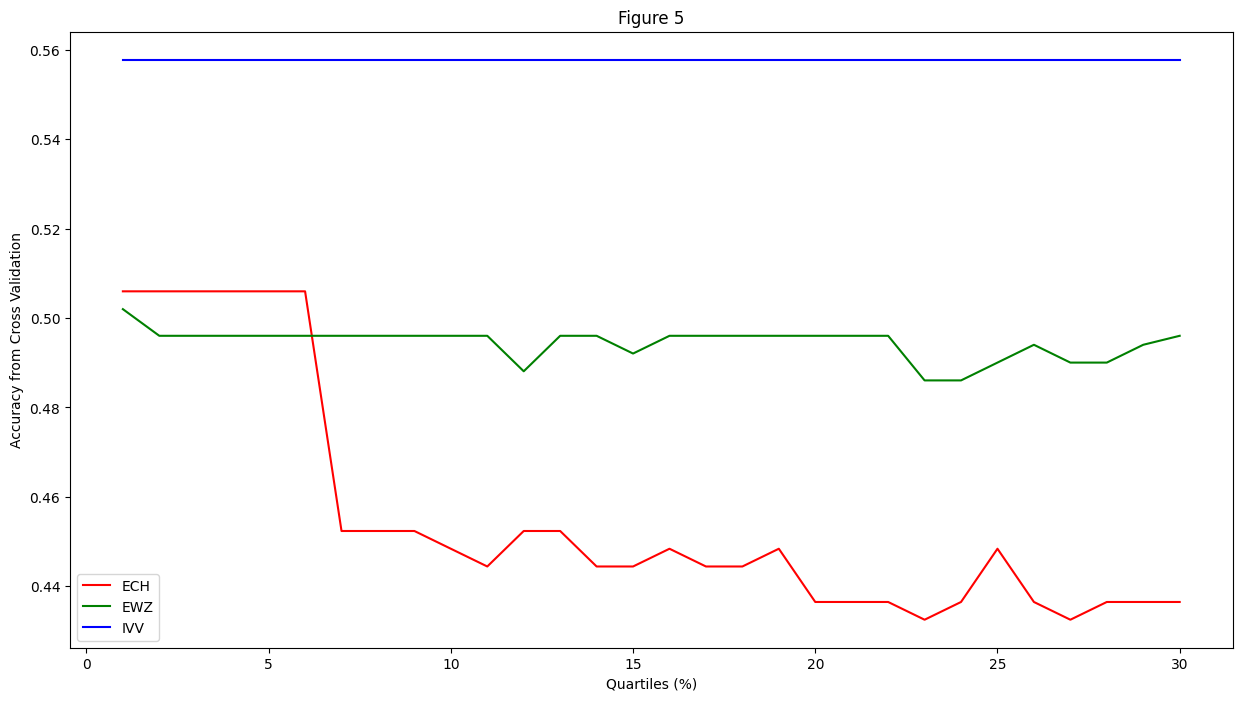

In [91]:
# Individual Min data
accuracy_individual_quartile_min = pd.DataFrame(results["Min"])
accuracy_individual_quartile_min.index = quartile_sequence
accuracy_individual_quartile_min.index.name = "Quartile"

# Reproducing graph in figure 2
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(accuracy_individual_quartile_min.index, accuracy_individual_quartile_min["ECH"], color = "red")
ax.plot(accuracy_individual_quartile_min.index, accuracy_individual_quartile_min["EWZ"], color = "green")
ax.plot(accuracy_individual_quartile_min.index, accuracy_individual_quartile_min["IVV"], color = "blue")
plt.legend(ETFs)
plt.xlabel("Quartiles (%)")
plt.ylabel("Accuracy from Cross Validation")
plt.title("Figure 5")
plt.show()

fig.savefig("Figure 5 Accuracy from Cross Validation (Min).png", bbox_inches = "tight")

## Part 2 : 

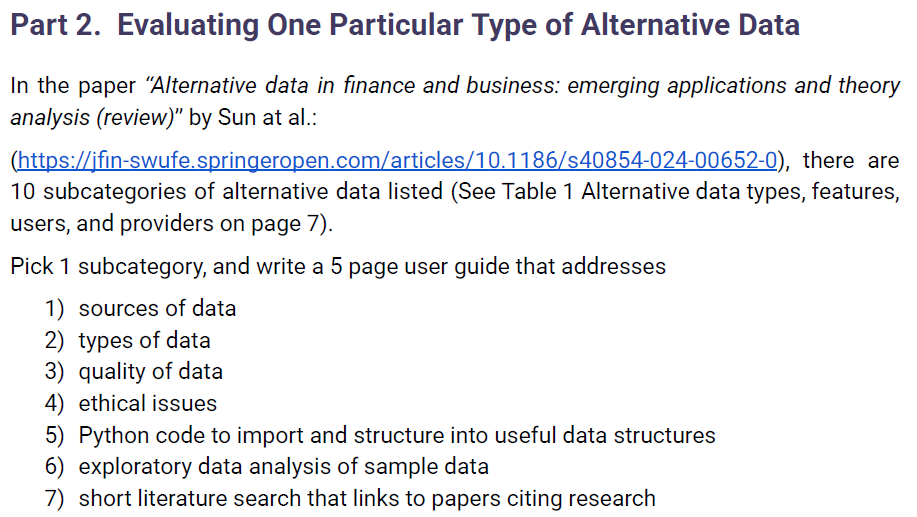

## 5) Python code to import and structure into useful data structures

In [1]:
# Essential libraries for geolocation data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Geospatial processing libraries
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [2]:
def generate_sample_geolocation_data():
    np.random.seed(42)
    
    dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
    store_locations = {
        'Store_A': {'geometry': Point(-74.0059, 40.7128), 'type': 'Urban'},
        'Store_B': {'geometry': Point(-118.2437, 34.0522), 'type': 'Suburban'},
        'Store_C': {'geometry': Point(-87.6298, 41.8781), 'type': 'Urban'}
    }
    
    data = []
    for date in dates:
        for store_id, properties in store_locations.items():
            day_of_week = date.dayofweek
            month = date.month
            
            base_traffic = 500 + 200 * np.sin(2 * np.pi * month / 12)
            weekly_effect = 150 if day_of_week >= 5 else 0
            noise = np.random.normal(0, 50)
            
            foot_traffic = max(100, base_traffic + weekly_effect + noise)
            dwell_time = np.random.normal(25, 10)
            
            data.append({
                'date': date,
                'store_id': store_id,
                'location_type': properties['type'],
                'foot_traffic': int(foot_traffic),
                'dwell_time': dwell_time,
                'geometry': properties['geometry']
            })
    
    return gpd.GeoDataFrame(data, crs="EPSG:4326")


In [3]:
# Generate and inspect data
geolocation_gdf = generate_sample_geolocation_data()
print("Sample Data Overview:")
print(geolocation_gdf.head())
print(f"Dataset shape: {geolocation_gdf.shape}")


Sample Data Overview:
        date store_id location_type  foot_traffic  dwell_time  \
0 2024-01-01  Store_A         Urban           624   23.617357   
1 2024-01-01  Store_B      Suburban           632   40.230299   
2 2024-01-01  Store_C         Urban           588   22.658630   
3 2024-01-02  Store_A         Urban           678   32.674347   
4 2024-01-02  Store_B      Suburban           576   30.425600   

                    geometry  
0   POINT (-74.0059 40.7128)  
1  POINT (-118.2437 34.0522)  
2   POINT (-87.6298 41.8781)  
3   POINT (-74.0059 40.7128)  
4  POINT (-118.2437 34.0522)  
Dataset shape: (1098, 6)


## 6) Exploratory Data Analysis of Sample Data

In [4]:
def perform_comprehensive_eda(geolocation_gdf):
    # Create summary statistics
    summary_stats = geolocation_gdf.groupby('store_id').agg({
        'foot_traffic': ['mean', 'std', 'min', 'max'],
        'dwell_time': ['mean', 'std']
    }).round(2)
    
    # Create visualization
    fig,( ax1, ax2) = plt.subplots( 1, 2, figsize = ( 15, 6))
    
    # Foot traffic by store
    geolocation_gdf.groupby('store_id')['foot_traffic'].mean().plot(
        kind='bar', ax=ax1, color=['skyblue', 'lightcoral', 'lightgreen']
    )
    ax1.set_title('Average Foot Traffic by Store', fontweight='bold')
    ax1.set_ylabel('Average Daily Visitors')
    
    # Traffic trends over time (monthly)
    geolocation_gdf['month'] = geolocation_gdf['date'].dt.month
    monthly_traffic = geolocation_gdf.groupby(['month', 'store_id'])['foot_traffic'].mean().unstack()
    monthly_traffic.plot(ax=ax2, linewidth=2.5)
    ax2.set_title('Monthly Foot Traffic Trends', fontweight='bold')
    ax2.set_ylabel('Average Visitors')
    ax2.set_xlabel('Month')
    ax2.legend(title='Store')
    
    plt.tight_layout()
    plt.show()
    
    return summary_stats


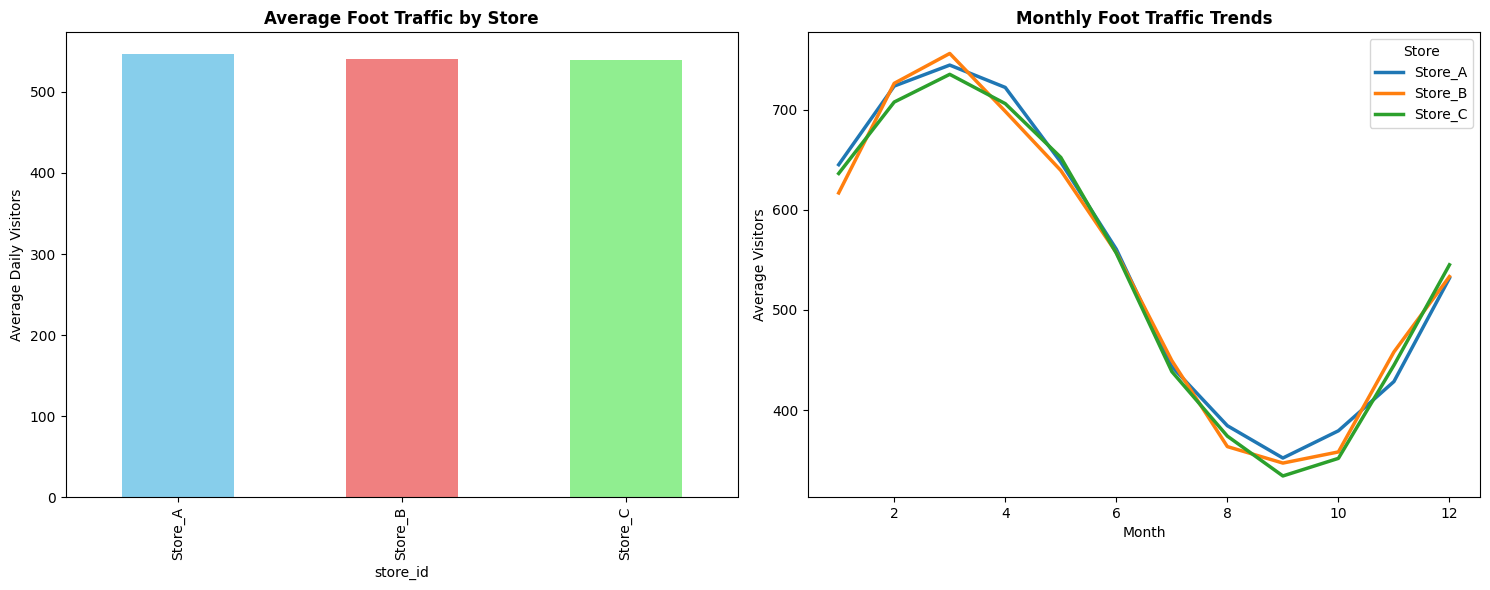

Summary Statistics:
         foot_traffic                   dwell_time       
                 mean     std  min  max       mean    std
store_id                                                 
Store_A        546.28  162.84  220  922      25.02  10.25
Store_B        541.24  164.63  178  957      25.77   9.97
Store_C        539.60  164.95  191  948      25.80  10.04


In [5]:
# Perform EDA
summary_results = perform_comprehensive_eda(geolocation_gdf)
print("Summary Statistics:")
print(summary_results)
